Módulo 2: Preparación y Limpieza Avanzada de Datos

Autor: Natalia Betancur Herrera

Objetivos de la clase:

- Aplicar técnicas de imputación de valores faltantes
- Detectar y tratar outliers
- Normalizar y estandarizar variables
- Codificar variables categóricas

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# URL del archivo Excel en GitHub
url = 'https://github.com/NataliaBetancurH/Curso_Analisis_De_Datos_Con_Python/raw/main/datos_ventas_limpieza_avanzada.xlsx'
df_original = pd.read_excel(url)

In [3]:
# Crear una copia del dataset
df = df_original.copy()


# Revisar que se haya leido de forma correcta
print("Vista previa (primeras 5 filas):")
df.head()

Vista previa (primeras 5 filas):


,id_pedido,fecha_pedido,categoria,region,cantidad,precio_unitario,descuento,calificacion,metodo_pago,vendedor
0,1,2023-01-01,Bebidas,NaN,NaN,NaN,20.0,NaN,efectivo,Ana
1,2,2023-01-02,Snacks,Norte,5.0,NaN,50.0,NaN,NaN,Maria
2,3,2023-01-03,CAFÉ,NaN,5.0,NaN,10.0,2.0,Efectivo,ANA
3,4,2023-01-04,Snacks,Norte,10.0,NaN,0.0,NaN,Efectivo,Maria
4,5,2023-01-05,Snacks,norte,1.0,1000.0,50.0,2.0,Transferencia,Maria


In [4]:
# Información del dataframe
print(f"   Registros: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"   Valores faltantes: {df.isnull().sum().sum():,}")

   Registros: 300
   Columnas: 10
   Valores faltantes: 477


In [5]:
# Análisis inicial de valores faltantes


# Imprime un encabezado informativo en consola
print("\n Valores faltantes por columna:")

# Calcula el número de valores nulos (NaN) en cada columna del DataFrame
valores_nulos = df.isnull().sum()

# Filtra únicamente las columnas que tienen al menos un valor faltante y las ordena de mayor a menor cantidad de nulos
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

# Verifica si existen columnas con valores faltantes
if len(valores_nulos) > 0:

    # Recorre cada columna con valores nulos
    for col, count in valores_nulos.items():

        # Calcula el porcentaje de valores faltantes respecto al total de registros
        porcentaje = (count / len(df)) * 100

        # Imprime el nombre de la columna, la cantidad de valores faltantes y su porcentaje correspondiente
        print(f"   • {col:<20}: {count:>4} ({porcentaje:>5.1f}%)")

else:
    # Mensaje informativo cuando no se detectan valores faltantes
    print("   No hay valores faltantes")


 Valores faltantes por columna:
   • categoria           :   73 ( 24.3%)
   • region              :   72 ( 24.0%)
   • precio_unitario     :   72 ( 24.0%)
   • metodo_pago         :   63 ( 21.0%)
   • cantidad            :   56 ( 18.7%)
   • vendedor            :   49 ( 16.3%)
   • descuento           :   48 ( 16.0%)
   • calificacion        :   44 ( 14.7%)


# TÉCNICAS DE IMPUTACIÓN DE VALORES FALTANTES

VALORES FALTANTES: Datos ausentes en el dataset.

TIPOS DE VALORES FALTANTES:

1. MCAR (Missing Completely At Random)

Ausencia completamente aleatoria. Los valores faltantes no dependen de ninguna variable observada ni del valor que falta. La ausencia ocurre de manera totalmente aleatoria dentro del conjunto de datos.

Nota: La eliminación de registros o la imputación simple suele ser segura, ya que no introduce sesgos significativos.

2. MAR (Missing At Random)

Ausencia relacionada con otras variables observadas Los valores faltantes dependen de una o más variables presentes en el dataset, pero no del valor faltante en sí.

Nota: Es recomendable utilizar imputaciones informadas, aprovechando la relación con otras variables para reducir el sesgo.

3. MNAR (Missing Not At Random)

Ausencia relacionada con el valor faltante. La probabilidad de que un dato esté ausente depende directamente del valor que debería tener. Este es el caso más complejo de manejar.

Nota: La imputación simple puede ser riesgosa. Se requieren análisis más profundos, supuestos explícitos o información externa para tratar adecuadamente estos faltantes.

ESTRATEGIAS DE IMPUTACIÓN:

A. ELIMINACIÓN:
   - Listwise: Eliminar filas con cualquier valor faltante
   - Pairwise: Eliminar solo para análisis específicos
   
B. IMPUTACIÓN SIMPLE:
   - Media: Para distribuciones normales sin outliers
   - Mediana: Para distribuciones con outliers o asimétricas
   - Moda: Para variables categóricas
   - Constante: Valor fijo (0, "Desconocido", etc.)

C. IMPUTACIÓN AVANZADA:
   - Forward Fill: Usar valor anterior (series temporales)
   - Backward Fill: Usar valor siguiente (series temporales)
   - Interpolación: Calcular valor intermedio
   - KNN: Basado en k vecinos más cercanos
   - Regresión: Predecir valores faltantes



In [6]:
# Crear copia para trabajar
df_imputado = df.copy()

## Análisis previo a la imputación

Antes de imputar, es necesario entender la distribución de cada variable para elegir la estrategia correcta.

In [7]:
# Análisis de la distribución de variables numéricas que presentan valores faltantes


# Seleccionar columnas numéricas del DataFrame imputado y quedarnos solo con aquellas que tienen al menos un valor nulo
columnas_numericas_con_nulos = (
    df_imputado
    .select_dtypes(include=[np.number])      # Solo variables numéricas
    .columns[
        df_imputado
        .select_dtypes(include=[np.number])
        .isnull()
        .any()                               # Columnas con al menos un NaN
    ]
)

# Encabezado del reporte
print("\n Estadísticas de variables numéricas con valores faltantes:")
print("─" * 80)

# Analizar cada columna numérica con valores faltantes
for col in columnas_numericas_con_nulos:

    # Verificar que efectivamente tenga valores nulos
    if df_imputado[col].isnull().sum() > 0:

        # Eliminar valores nulos para analizar solo datos observados
        serie = df_imputado[col].dropna()


        # Cálculo de estadísticas descriptivas

        media = serie.mean()                 # Promedio
        mediana = serie.median()             # Valor central
        moda = serie.mode()[0] if len(serie.mode()) > 0 else np.nan
        std = serie.std()                    # Dispersión
        skewness = serie.skew()              # Asimetría de la distribución

        # Mostrar estadísticas
        print(f"\n{col}:")
        print(f"   • Media: {media:.2f}")
        print(f"   • Mediana: {mediana:.2f}")
        print(f"   • Moda: {moda:.2f}")
        print(f"   • Desv. Estándar: {std:.2f}")
        print(f"   • Asimetría (Skewness): {skewness:.2f}")


        # Recomendación del método de imputación basada en la forma de la distribución

        # Distribución aproximadamente simétrica
        if abs(skewness) < 0.5:
            recomendacion = "Imputar con la media (distribución simétrica)"

        # Distribución sesgada
        else:
            recomendacion = "Imputar con la mediana (distribución asimétrica)"

        print(f"   • Recomendación: {recomendacion}")


 Estadísticas de variables numéricas con valores faltantes:
────────────────────────────────────────────────────────────────────────────────

cantidad:
   • Media: 56.56
   • Mediana: 3.00
   • Moda: 10.00
   • Desv. Estándar: 153.50
   • Asimetría (Skewness): 2.56
   • Recomendación: Imputar con la mediana (distribución asimétrica)

precio_unitario:
   • Media: 133.61
   • Mediana: 5.00
   • Moda: -10.00
   • Desv. Estándar: 338.05
   • Asimetría (Skewness): 2.19
   • Recomendación: Imputar con la mediana (distribución asimétrica)

descuento:
   • Media: 36.35
   • Mediana: 20.00
   • Moda: 120.00
   • Desv. Estándar: 43.35
   • Asimetría (Skewness): 1.15
   • Recomendación: Imputar con la mediana (distribución asimétrica)

calificacion:
   • Media: 3.51
   • Mediana: 3.00
   • Moda: 2.00
   • Desv. Estándar: 1.95
   • Asimetría (Skewness): 0.45
   • Recomendación: Imputar con la media (distribución simétrica)


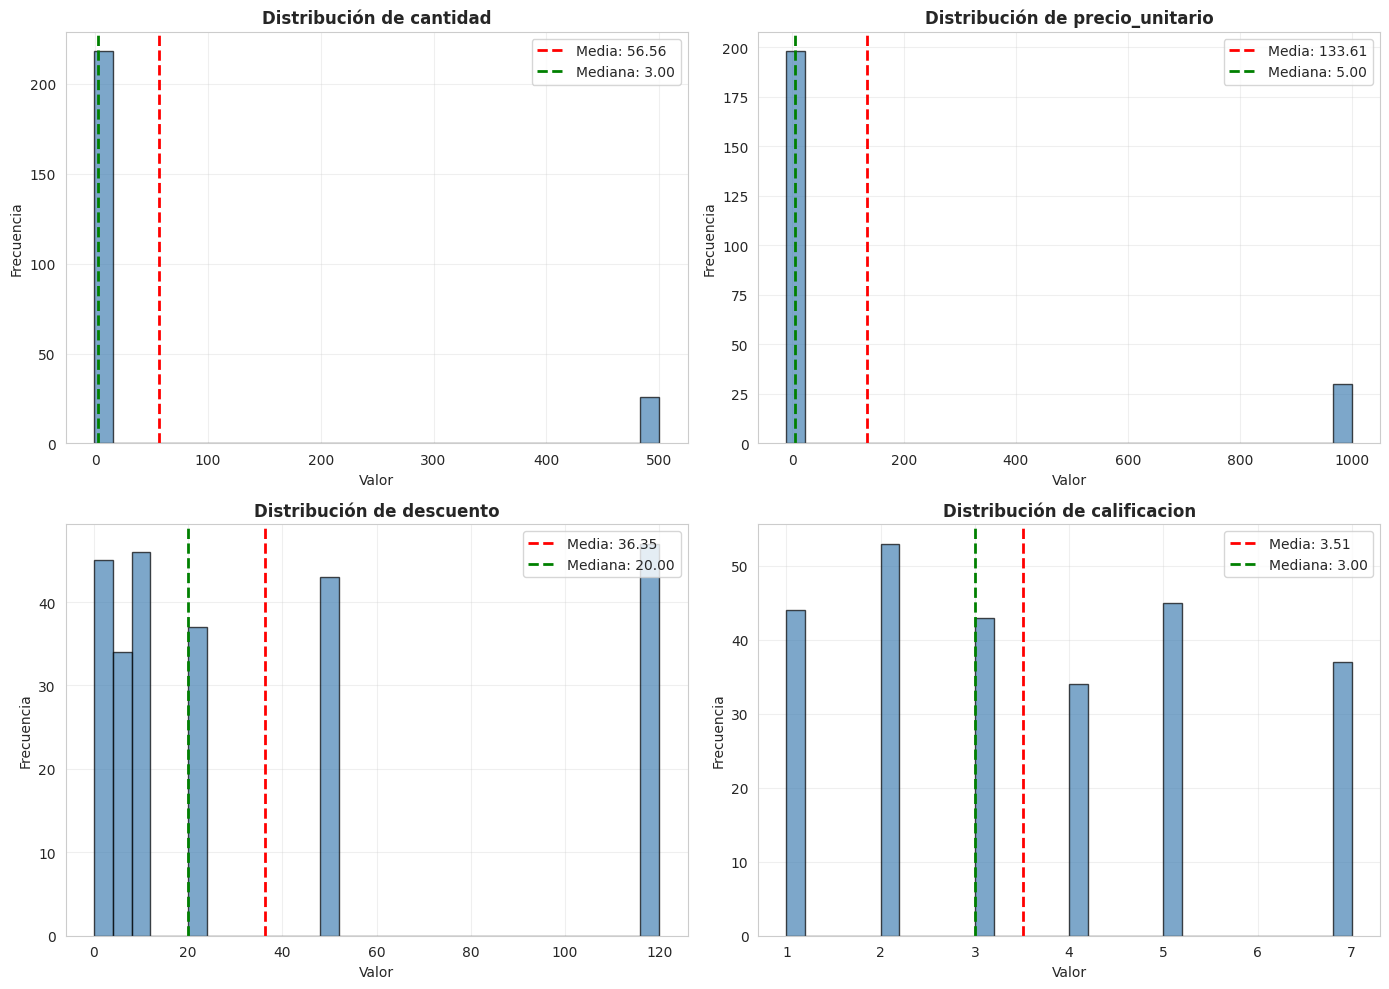


 Gráfico guardado: 'imputacion_1_distribucion_variables.png'


In [8]:

# Visualización de distribuciones de variables numéricas con valores faltantes


# Verificar que existan columnas numéricas con valores nulos
if len(columnas_numericas_con_nulos) > 0:

    # Crear una cuadrícula de subgráficos (2 filas x 2 columnas)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Convertir la matriz de ejes en una lista plana para facilitar su recorrido con un solo índice
    axes = axes.ravel()

    # Iterar sobre un máximo de 4 columnas para visualizar
    for idx, col in enumerate(columnas_numericas_con_nulos[:4]):

        # Eliminar valores nulos para analizar la distribución real
        serie = df_imputado[col].dropna()


        # Histograma de la variable
        axes[idx].hist(
            serie,
            bins=30,                   # Número de bins
            edgecolor='black',
            alpha=0.7,
            color='steelblue'
        )

        # Línea vertical para la media
        axes[idx].axvline(
            serie.mean(),
            color='red',
            linestyle='--',
            linewidth=2,
            label=f'Media: {serie.mean():.2f}'
        )

        # Línea vertical para la mediana
        axes[idx].axvline(
            serie.median(),
            color='green',
            linestyle='--',
            linewidth=2,
            label=f'Mediana: {serie.median():.2f}'
        )

        # Etiquetas y título
        axes[idx].set_xlabel('Valor', fontsize=10)
        axes[idx].set_ylabel('Frecuencia', fontsize=10)
        axes[idx].set_title(
            f'Distribución de {col}',
            fontsize=12,
            fontweight='bold'
        )

        # Mostrar leyenda y cuadrícula
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

    # Ajustar automáticamente los espacios entre subgráficos
    plt.tight_layout()

    # Guardar la figura como imagen
    plt.savefig(
        'imputacion_1_distribucion_variables.png',
        dpi=300,
        bbox_inches='tight'
    )

    # Mostrar la figura
    plt.show()

    # Confirmación en consola
    print("\n Gráfico guardado: 'imputacion_1_distribucion_variables.png'")

##Imputación por Media

Definición:

La imputación por media consiste en reemplazar los valores faltantes de una variable numérica por el promedio aritmético de los valores observados. Es una técnica sencilla y ampliamente utilizada cuando se busca mantener el tamaño del conjunto de datos sin introducir valores extremos.

Cuándo utilizarla:

* En variables numéricas continuas.

* Cuando la distribución de los datos es aproximadamente simétrica y no presenta outliers significativos.

* Cuando los valores faltantes representan una proporción pequeña del total de registros.

Consideración importante:

Esta técnica puede reducir la variabilidad de los datos y no es recomendable en distribuciones sesgadas, ya que puede introducir distorsiones en el análisis.


Ventajas:
+ Simple de calcular
+ Mantiene la media original
+ Ampliamente utilizada

Desventajas:
- Sensible a outliers
- Reduce la varianza
- No captura patrones complejos

In [9]:
# Ejemplo Imputación de valores faltantes usando la MEDIA
# Variable: cantidad


# Verificar que la columna cantidad exista y que tenga valores faltantes
if 'cantidad' in df_imputado.columns and df_imputado['cantidad'].isnull().sum() > 0:

    print("\nEjemplo: Imputación de 'cantidad' con media")


    # Estado inicial antes de la imputación


    # Contar cuántos valores faltantes hay antes de imputar
    nulos_antes = df_imputado['cantidad'].isnull().sum()

    # Calcular la media original (pandas ignora automáticamente los NaN)
    media_antes = df_imputado['cantidad'].mean()

    # Mostrar información inicial
    print(f"   • Valores faltantes: {nulos_antes}")
    print(f"   • Media calculada: {media_antes:.2f}")


    # Imputación con la media


    # Reemplazar los valores NaN por la media calculada
    df_imputado['cantidad'] = df_imputado['cantidad'].fillna(media_antes)


    # Verificación después de la imputación


    # Contar valores faltantes después de imputar
    nulos_despues = df_imputado['cantidad'].isnull().sum()

    # Recalcular la media después de la imputación
    media_despues = df_imputado['cantidad'].mean()

    # Mostrar resultados finales
    print(f"   • Valores faltantes después: {nulos_despues}")
    print(f"   • Media después de imputar: {media_despues:.2f}")

    # Confirmación del proceso
    print(f"   ✓ {nulos_antes} valores imputados con la media")


Ejemplo: Imputación de 'cantidad' con media
   • Valores faltantes: 56
   • Media calculada: 56.56
   • Valores faltantes después: 0
   • Media después de imputar: 56.56
   ✓ 56 valores imputados con la media


## Imputación por Mediana

Definición:

La imputación por mediana consiste en reemplazar los valores faltantes de una variable numérica por la mediana de los valores observados. La mediana representa el valor central de la distribución y es robusta frente a valores extremos, lo que la convierte en una alternativa más segura que la media en muchos escenarios reales.

Cuándo utilizarla:

* En variables numéricas continuas u ordinales.

* Cuando la distribución de los datos es asimétrica o sesgada.

* En presencia de outliers que podrían distorsionar la media.

* Cuando los valores faltantes no siguen un patrón completamente aleatorio.

Consideración importante:

Aunque la imputación por mediana reduce el impacto de valores extremos, no preserva la forma completa de la distribución original ni captura relaciones entre variables. Debe utilizarse como una solución práctica cuando no se dispone de información adicional para una imputación más avanzada.

Ventajas

* Robusta frente a outliers
* Fácil de calcular e interpretar
* Mantiene la posición central real de la distribución
* Más estable que la media en distribuciones sesgadas

Desventajas

* Reduce la variabilidad de los datos
* No conserva la media original
* No modela relaciones ni patrones complejos entre variables

In [10]:

# Ejemplo Imputación valores faltantes con mediana
# Variable: precio_unitario


# Verificar que la columna exista y que tenga valores faltantes
if 'precio_unitario' in df_imputado.columns and df_imputado['precio_unitario'].isnull().sum() > 0:

    print("\nEjemplo: Imputación de 'precio_unitario' con mediana")

    # Contar valores faltantes antes de la imputación
    nulos_antes = df_imputado['precio_unitario'].isnull().sum()

    # Calcular la mediana ignorando valores nulos
    mediana_precio = df_imputado['precio_unitario'].median()

    # Mostrar diagnóstico inicial
    print(f"   • Valores faltantes: {nulos_antes}")
    print(f"   • Mediana calculada: ${mediana_precio:.2f}")

    # Reemplazar valores nulos por la mediana
    df_imputado['precio_unitario'] = df_imputado['precio_unitario'].fillna(mediana_precio)

    # Verificar que ya no existan valores faltantes
    nulos_despues = df_imputado['precio_unitario'].isnull().sum()

    # Confirmación del proceso
    print(f"   • Valores faltantes después: {nulos_despues}")
    print(f"   ✓ {nulos_antes} valores imputados con mediana")



Ejemplo: Imputación de 'precio_unitario' con mediana
   • Valores faltantes: 72
   • Mediana calculada: $5.00
   • Valores faltantes después: 0
   ✓ 72 valores imputados con mediana


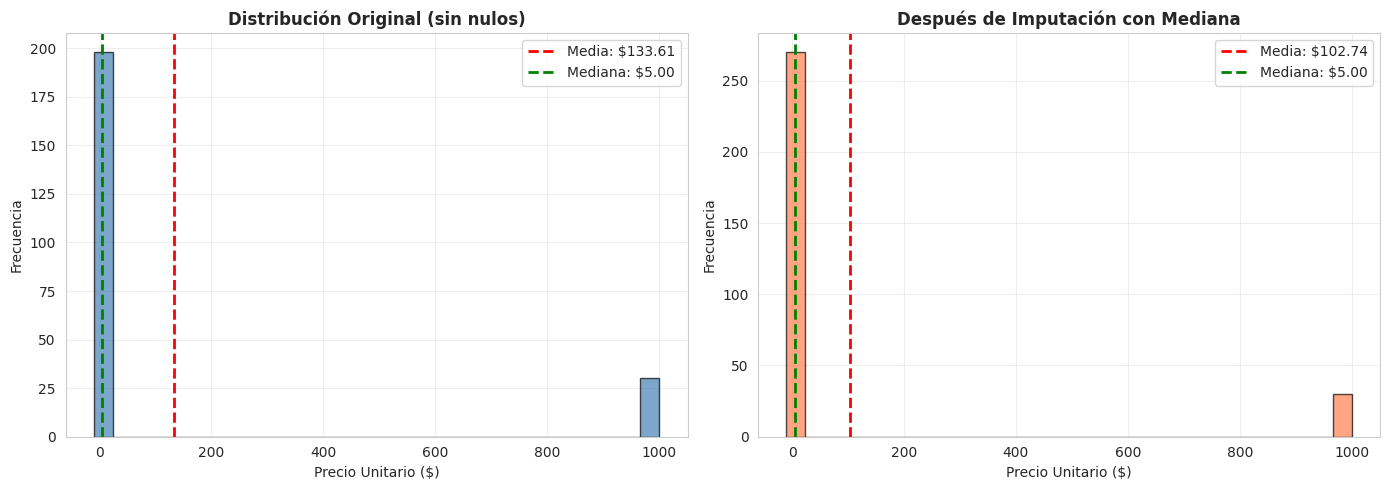


✓ Gráfico guardado: 'imputacion_2_media_vs_mediana.png'


In [11]:

# Comparación visual Media y Mediana
# Objetivo: Analizar el impacto de la imputación


# Verificar que la columna exista en el DataFrame original
if 'precio_unitario' in df.columns:

    # Crear figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


    # Gráfico 1 Distribución original (sin valores nulos)
    serie_original = df['precio_unitario'].dropna()

    ax1.hist(
        serie_original,
        bins=30,
        edgecolor='black',
        alpha=0.7,
        color='steelblue'
    )

    # Línea de la media
    ax1.axvline(
        serie_original.mean(),
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Media: ${serie_original.mean():.2f}'
    )

    # Línea de la mediana
    ax1.axvline(
        serie_original.median(),
        color='green',
        linestyle='--',
        linewidth=2,
        label=f'Mediana: ${serie_original.median():.2f}'
    )

    ax1.set_title('Distribución Original (sin nulos)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Precio Unitario ($)', fontsize=10)
    ax1.set_ylabel('Frecuencia', fontsize=10)
    ax1.legend()
    ax1.grid(alpha=0.3)



    # Gráfico 2 Distribución después de la imputación con mediana

    ax2.hist(
        df_imputado['precio_unitario'],
        bins=30,
        edgecolor='black',
        alpha=0.7,
        color='coral'
    )

    # Media posterior a la imputación
    ax2.axvline(
        df_imputado['precio_unitario'].mean(),
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Media: ${df_imputado["precio_unitario"].mean():.2f}'
    )

    # Mediana posterior a la imputación
    ax2.axvline(
        df_imputado['precio_unitario'].median(),
        color='green',
        linestyle='--',
        linewidth=2,
        label=f'Mediana: ${df_imputado["precio_unitario"].median():.2f}'
    )

    ax2.set_title('Después de Imputación con Mediana', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Precio Unitario ($)', fontsize=10)
    ax2.set_ylabel('Frecuencia', fontsize=10)
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Ajustar diseño y guardar figura
    plt.tight_layout()
    plt.savefig('imputacion_2_media_vs_mediana.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✓ Gráfico guardado: 'imputacion_2_media_vs_mediana.png'")

## Imputación por Moda

Definición:

La imputación por moda consiste en reemplazar los valores faltantes de una variable por el valor más frecuente (la moda) observado en los datos. Este método es especialmente útil cuando se trabaja con variables categóricas o discretas, donde el concepto de promedio no es representativo.

A diferencia de la media o la mediana, la moda refleja el comportamiento más común del conjunto de datos.

Cuándo utilizarla:

* Se trabaja con variables categóricas (por ejemplo: tipo de producto, método de pago, ciudad).
* Se trabaja con variables discretas con pocos valores posibles.
* La moda representa claramente un valor dominante.
* Se busca mantener la coherencia semántica de los datos.
* El porcentaje de valores faltantes es relativamente bajo.

Consideración importante:

La imputación por moda puede sobrerrepresentar artificialmente el valor más frecuente, especialmente cuando existen varias modas o cuando la distribución está muy desequilibrada. Además, no introduce variabilidad nueva y puede amplificar sesgos existentes en los datos.

Ventajas:

* Muy sencilla de implementar
* Ideal para variables categóricas
* No genera valores irreales
* Fácil de interpretar y comunicar
* Mantiene la coherencia del dominio de la variable

Desventajas:

* Puede reforzar sesgos existentes
* Reduce la variabilidad del conjunto de datos
* No es adecuada para variables continuas
* No captura relaciones entre variables
* Puede distorsionar proporciones reales si hay muchos nulos

In [12]:
# Imputación de valores con Moda
# Variables categóricas: vendedor y cliente


# Verificar que la columna exista en el DataFrame y que tenga valores faltantes
if 'vendedor' in df_imputado.columns and df_imputado['vendedor'].isnull().sum() > 0:

    print("\nEjemplo Imputación de vendedor con moda")

    # 1. Convertir toda la columna a mayúsculas
    df_imputado['vendedor'] = df_imputado['vendedor'].str.upper()


    # 2. Contar valores faltantes antes de la imputación
    nulos_antes = df_imputado['vendedor'].isnull().sum()

    # 3. Calcular la moda de la columna vendedor
    moda_vendedor = df_imputado['vendedor'].mode()[0]

    # Mostrar información diagnóstica
    print(f"   • Valores faltantes antes: {nulos_antes}")
    print(f"   • Moda calculada: '{moda_vendedor}'")

    # 3. Mostrar la distribución de frecuencias
    print(f"\n   • Top 5 vendedores más frecuentes:")

    top_vendedores = df_imputado['vendedor'].value_counts().head(5)

    for vendedor, count in top_vendedores.items():
        print(f"      - {vendedor}: {count} ventas")

    # 4. Imputar los valores faltantes usando la moda
    df_imputado['vendedor'] = df_imputado['vendedor'].fillna(moda_vendedor)

    # 5. Verificar el resultado después de la imputación
    nulos_despues = df_imputado['vendedor'].isnull().sum()

    print(f"\n   • Valores faltantes después: {nulos_despues}")
    print(f"   ✓ {nulos_antes} valores imputados con moda")




Ejemplo Imputación de vendedor con moda
   • Valores faltantes antes: 49
   • Moda calculada: 'ANA'

   • Top 5 vendedores más frecuentes:
      - ANA: 104 ventas
      - CARLOS: 54 ventas
      - LUIS: 51 ventas
      - MARIA: 42 ventas

   • Valores faltantes después: 0
   ✓ 49 valores imputados con moda


## Imputación con constante

Definición:

La imputación con constante consiste en reemplazar los valores faltantes de una variable por un valor fijo previamente definido (por ejemplo, 0, “DESCONOCIDO”, “SIN DATOS”). Este método asegura que no queden valores nulos en el conjunto de datos y permite identificar fácilmente los registros imputados.

Cuándo utilizarla:
- En variables categóricas donde se desea marcar explícitamente la ausencia de información.
- En variables numéricas cuando un valor específico (como 0) tiene un significado claro en el contexto.
- En escenarios donde es importante diferenciar los datos originales de los imputados.
- Cuando se busca simplicidad y rapidez en el tratamiento de valores faltantes.

Consideración importante:

La imputación con constante puede introducir sesgos si el valor elegido no refleja adecuadamente la distribución de los datos. Además, puede afectar modelos estadísticos o de machine learning al crear una categoría artificial o un valor numérico que no representa la realidad.

Ventajas:
- Fácil de implementar y comprender.
- Elimina todos los valores nulos de manera inmediata.
- Permite identificar claramente los registros imputados.
- Útil en variables categóricas para marcar “SIN INFORMACIÓN”.

Desventajas:
- Puede distorsionar la distribución original de los datos.
- Introduce un valor artificial que no siempre tiene significado estadístico.
- Puede afectar negativamente el rendimiento de modelos predictivos si no se maneja con cuidado.
- No preserva relaciones entre variables ni patrones complejos.


In [13]:
# Ejemplo con descuento (0 significa sin descuento)
if 'descuento' in df_imputado.columns and df_imputado['descuento'].isnull().sum() > 0:
    print("\nEjemplo: Imputación de descuento con constante (0)")

    nulos_antes = df_imputado['descuento'].isnull().sum()
    print(f"   • Valores faltantes: {nulos_antes}")
    print(f"   • Lógica de negocio: Sin descuento = 0%")

    # Imputar con 0
    df_imputado['descuento'] = df_imputado['descuento'].fillna(0)

    nulos_despues = df_imputado['descuento'].isnull().sum()
    print(f"   • Valores faltantes después: {nulos_despues}")
    print(f"   ✓ {nulos_antes} valores imputados con 0")


Ejemplo: Imputación de descuento con constante (0)
   • Valores faltantes: 48
   • Lógica de negocio: Sin descuento = 0%
   • Valores faltantes después: 0
   ✓ 48 valores imputados con 0


## KNN Imputer

Definición:

La imputación con KNN (K-Nearest Neighbors Imputer) consiste en reemplazar los valores faltantes utilizando la información de los registros más similares (vecinos más cercanos). El algoritmo busca las observaciones con valores completos que estén más próximas en el espacio de características y calcula el valor imputado como una media (o ponderación) de esos vecinos.

Cuándo utilizarla:
- En variables numéricas o mixtas donde la relación entre atributos es relevante.
- Cuando se dispone de un conjunto de datos con suficiente densidad y sin demasiados valores faltantes.
- En escenarios donde se desea preservar patrones y relaciones entre variables.
- En problemas donde la imputación simple (media, mediana, constante) no captura la complejidad de los datos.

Consideración importante:

El KNN Imputer puede ser computacionalmente costoso en conjuntos de datos grandes, ya que requiere calcular distancias entre observaciones. Además, la calidad de la imputación depende de la elección del número de vecinos (k) y de la métrica de distancia utilizada.

Ventajas:
- Aprovecha la información multivariante del dataset.
- Preserva relaciones entre variables.
- Puede producir imputaciones más realistas que métodos simples.
- Es flexible ya que se adapta a diferentes tipos de datos y métricas de distancia.

Desventajas:
- Computacionalmente más lento en datasets grandes.
- Sensible a la elección de k y de la métrica de distancia.
- Puede verse afectado por outliers o datos ruidosos.
- Requiere que el dataset tenga suficientes observaciones completas para que la imputación sea confiable


In [14]:
# Seleccionar solo columnas numéricas para KNN
columnas_numericas = ['cantidad', 'precio_unitario', 'descuento', 'subtotal', 'total']
columnas_disponibles = [col for col in columnas_numericas if col in df.columns]

if len(columnas_disponibles) > 0:
    # Crear dataset solo con numéricas para ejemplo de KNN
    df_numericas_original = df[columnas_disponibles].copy()

    # Verificar si hay nulos
    nulos_totales = df_numericas_original.isnull().sum().sum()

    if nulos_totales > 0:
        print(f"\n   • Total de valores faltantes en variables numéricas: {nulos_totales}")

        # Aplicar KNN Imputer
        knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
        df_knn_imputado = pd.DataFrame(
            knn_imputer.fit_transform(df_numericas_original),
            columns=columnas_disponibles
        )

        print(f"   • Valores faltantes después de KNN: {df_knn_imputado.isnull().sum().sum()}")
        print(f"   ✓ KNN imputación completada")


   • Total de valores faltantes en variables numéricas: 176
   • Valores faltantes después de KNN: 0
   ✓ KNN imputación completada


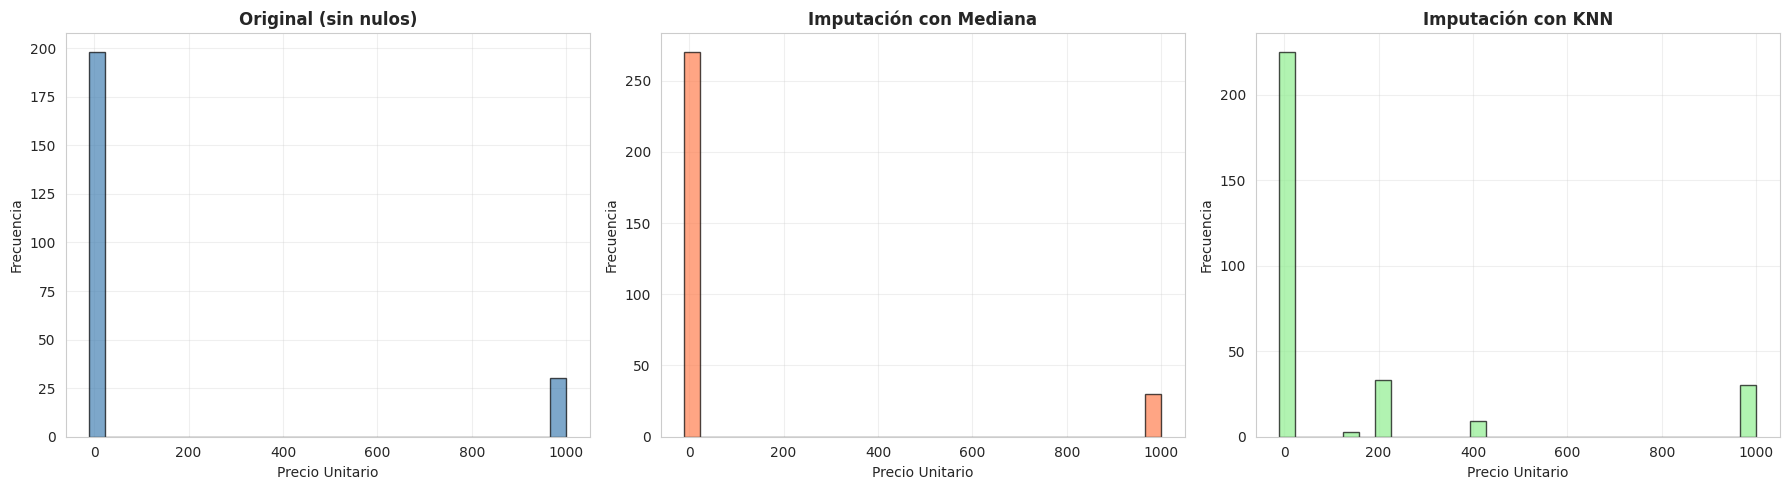


✓ Gráfico guardado: 'imputacion_3_comparacion_metodos.png'


In [15]:
# Comparación visual

if 'precio_unitario' in columnas_disponibles:  # Verifica si la columna precio_unitario está en el DataFrame
    # Crea una figura con 3 subgráficos (horizontal) y tamaño 18x5 pulgadas
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Primer histograma: datos originales
    axes[0].hist(df_numericas_original['precio_unitario'].dropna(), bins=30,
                 edgecolor='black', alpha=0.7, color='steelblue')  # Histograma de la columna original sin valores nulos
    axes[0].set_title('Original (sin nulos)', fontsize=12, fontweight='bold')  # Título del histograma
    axes[0].set_xlabel('Precio Unitario', fontsize=10)  # Etiqueta eje X
    axes[0].set_ylabel('Frecuencia', fontsize=10)  # Etiqueta eje Y
    axes[0].grid(alpha=0.3)  # Malla ligera para facilitar la lectura de frecuencias

    # Segundo histograma: imputación simple (mediana)
    axes[1].hist(df_imputado['precio_unitario'], bins=30,
                 edgecolor='black', alpha=0.7, color='coral')  # Histograma de la columna con valores faltantes reemplazados por la mediana
    axes[1].set_title('Imputación con Mediana', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Precio Unitario', fontsize=10)
    axes[1].set_ylabel('Frecuencia', fontsize=10)
    axes[1].grid(alpha=0.3)

    # Tercer histograma: imputación usando KNN
    axes[2].hist(df_knn_imputado['precio_unitario'], bins=30,
                 edgecolor='black', alpha=0.7, color='lightgreen')  # Histograma de la columna imputada con KNN
    axes[2].set_title('Imputación con KNN', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Precio Unitario', fontsize=10)
    axes[2].set_ylabel('Frecuencia', fontsize=10)
    axes[2].grid(alpha=0.3)

    # Ajusta automáticamente el espaciado entre subgráficos para que no se sobrepongan etiquetas
    plt.tight_layout()

    # Guarda la figura como imagen PNG con buena resolución (300 dpi)
    plt.savefig('imputacion_3_comparacion_metodos.png', dpi=300, bbox_inches='tight')

    # Muestra el gráfico en pantalla
    plt.show()

    # Mensaje indicando que se guardó el gráfico
    print("\n✓ Gráfico guardado: 'imputacion_3_comparacion_metodos.png'")
else:
    # Mensaje informativo si no hay valores faltantes en variables numéricas
    print("   No hay valores faltantes en variables numéricas")

# DETECCIÓN Y TRATAMIENTO DE OUTLIERS

Outliers (Valores Atípicos):

Los outliers son observaciones que se alejan de manera significativa del patrón general de los datos. Pueden distorsionar estadísticas como la media y la desviación estándar, por lo que identificarlos y decidir cómo tratarlos es un paso clave en el análisis de datos.


Tipos de Outliers:

Univariados
- Se detectan al analizar una sola variable.
- Ejemplo: una persona con una altura de 2.30 m en un conjunto de datos de estaturas.

Multivariados
- Surgen de combinaciones inusuales de valores en varias variables.
- Ejemplo: un cliente con ingresos muy bajos pero con gastos extremadamente altos en tarjetas de crédito.


Causas Comunes:

- Errores de entrada de datos: valores digitados incorrectamente.
- Errores de medición: fallas en instrumentos o sensores.
- Variabilidad natural del proceso: diferencias legítimas dentro de un sistema.
- Eventos excepcionales legítimos: sucesos raros pero reales (ejemplo un pico de ventas por un evento inesperado).

Métodos de Detección:
1. IQR (Rango Intercuartílico)
- Q1 = Percentil 25
- Q3 = Percentil 75
- IQR = Q3 − Q1

Regla:
- Outlier si x < Q1-1.5 * IQR
- Outlier si x > Q3+1.5 * IQR

Ejemplo: En salarios, un valor muy por debajo o muy por encima del rango intercuartílico.


2. Z-Score (Puntuación Estándar)
- Fórmula:

$$
Z = \frac{x - \mu}{\sigma}
$$



- Regla:
- Outlier si |Z|>3 (criterio estricto)
- Outlier si |Z|>2 (criterio moderado)

Ejemplo: Una nota de examen muy superior o inferior respecto al promedio de la clase.

3. Visualización
- Boxplot (diagrama de caja): muestra valores extremos fuera de los bigotes.
- Scatter plot (diagrama de dispersión): revela puntos alejados del patrón general.
- Histogramas: evidencian valores aislados en las colas de la distribución.


Decisiones sobre Outliers:

- Eliminar: cuando son errores evidentes de captura o medición.
- Conservar: si reflejan variabilidad real y aportan información valiosa.
- Transformar: aplicar técnicas como winsorización (reemplazar valores extremos por límites) o capping (ajustar valores a un máximo/mínimo permitido).

Nota: los outliers no siempre son malos. A veces revelan información crítica (fraudes, oportunidades de negocio, fallas en procesos). La clave está en distinguir entre error y variabilidad legítima antes de decidir qué hacer con ellos.



## Detección de outliers con IQR

MÉTODO IQR:
1. Calcular Q1 (percentil 25) y Q3 (percentil 75)
2. Calcular IQR = Q3 - Q1
3. Límite inferior = Q1 - 1.5 * IQR
4. Límite superior = Q3 + 1.5 * IQR
5. Outliers: valores fuera de estos límites

In [16]:
# Ejemplo con cantidad
if 'cantidad' in df_imputado.columns:  # Verifica si la columna cantidad existe en el DataFrame imputado
    print("\nEjemplo Detección de outliers en cantidad")

    # Crear una serie sin valores nulos para trabajar
    serie_cantidad = df_imputado['cantidad'].dropna()

    # Calcular cuartiles e IQR
    Q1 = serie_cantidad.quantile(0.25)  # Primer cuartil (25%)
    Q3 = serie_cantidad.quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1  # Rango intercuartílico (IQR)

    # Calcular límites para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR  # Valores por debajo de este límite se consideran outliers inferiores
    limite_superior = Q3 + 1.5 * IQR  # Valores por encima de este límite se consideran outliers superiores

    # Detectar outliers
    outliers_inferiores = serie_cantidad[serie_cantidad < limite_inferior]  # Valores por debajo del límite inferior
    outliers_superiores = serie_cantidad[serie_cantidad > limite_superior]  # Valores por encima del límite superior
    total_outliers = len(outliers_inferiores) + len(outliers_superiores)  # Conteo total de outliers

    # Mostrar estadísticas
    print(f"\n   Estadísticas:")
    print(f"      • Q1 (25%): {Q1:.2f}")
    print(f"      • Q3 (75%): {Q3:.2f}")
    print(f"      • IQR: {IQR:.2f}")
    print(f"      • Límite inferior: {limite_inferior:.2f}")
    print(f"      • Límite superior: {limite_superior:.2f}")

    # Mostrar resultados de outliers
    print(f"\n   Resultados:")
    print(f"      • Total de outliers: {total_outliers} ({(total_outliers/len(serie_cantidad))*100:.2f}%)")
    print(f"      • Outliers inferiores: {len(outliers_inferiores)}")
    print(f"      • Outliers superiores: {len(outliers_superiores)}")

    # Mostrar algunos ejemplos de outliers superiores si existen
    if len(outliers_superiores) > 0:
        print(f"      • Ejemplos (superiores): {outliers_superiores.head(5).tolist()}")


Ejemplo Detección de outliers en cantidad

   Estadísticas:
      • Q1 (25%): 2.00
      • Q3 (75%): 56.56
      • IQR: 54.56
      • Límite inferior: -79.84
      • Límite superior: 138.39

   Resultados:
      • Total de outliers: 26 (8.67%)
      • Outliers inferiores: 0
      • Outliers superiores: 26
      • Ejemplos (superiores): [500.0, 500.0, 500.0, 500.0, 500.0]


In [17]:
# Ejemplo con precio_unitario
if 'precio_unitario' in df_imputado.columns:  # Verifica si la columna precio_unitario existe en el DataFrame
    print("\n\nEjemplo Detección de outliers en precio_unitario")

    # Crear una serie sin valores nulos para análisis
    serie_precio = df_imputado['precio_unitario'].dropna()

    # Calcular cuartiles e IQR
    Q1_precio = serie_precio.quantile(0.25)  # Primer cuartil (25%)
    Q3_precio = serie_precio.quantile(0.75)  # Tercer cuartil (75%)
    IQR_precio = Q3_precio - Q1_precio       # Rango intercuartílico (IQR)

    # Definir límites para detectar outliers
    limite_inf_precio = Q1_precio - 1.5 * IQR_precio  # Límite inferior (valores menores se consideran outliers)
    limite_sup_precio = Q3_precio + 1.5 * IQR_precio  # Límite superior (valores mayores se consideran outliers)

    # Identificar outliers
    outliers_precio = serie_precio[(serie_precio < limite_inf_precio) | (serie_precio > limite_sup_precio)]

    # Mostrar estadísticas y resultados
    print(f"\n   Estadísticas:")
    print(f"      • Q1: ${Q1_precio:.2f}")
    print(f"      • Q3: ${Q3_precio:.2f}")
    print(f"      • Límite superior: ${limite_sup_precio:.2f}")
    print(f"      • Total de outliers: {len(outliers_precio)} ({(len(outliers_precio)/len(serie_precio))*100:.2f}%)")





Ejemplo Detección de outliers en precio_unitario

   Estadísticas:
      • Q1: $2.50
      • Q3: $7.50
      • Límite superior: $15.00
      • Total de outliers: 77 (25.67%)


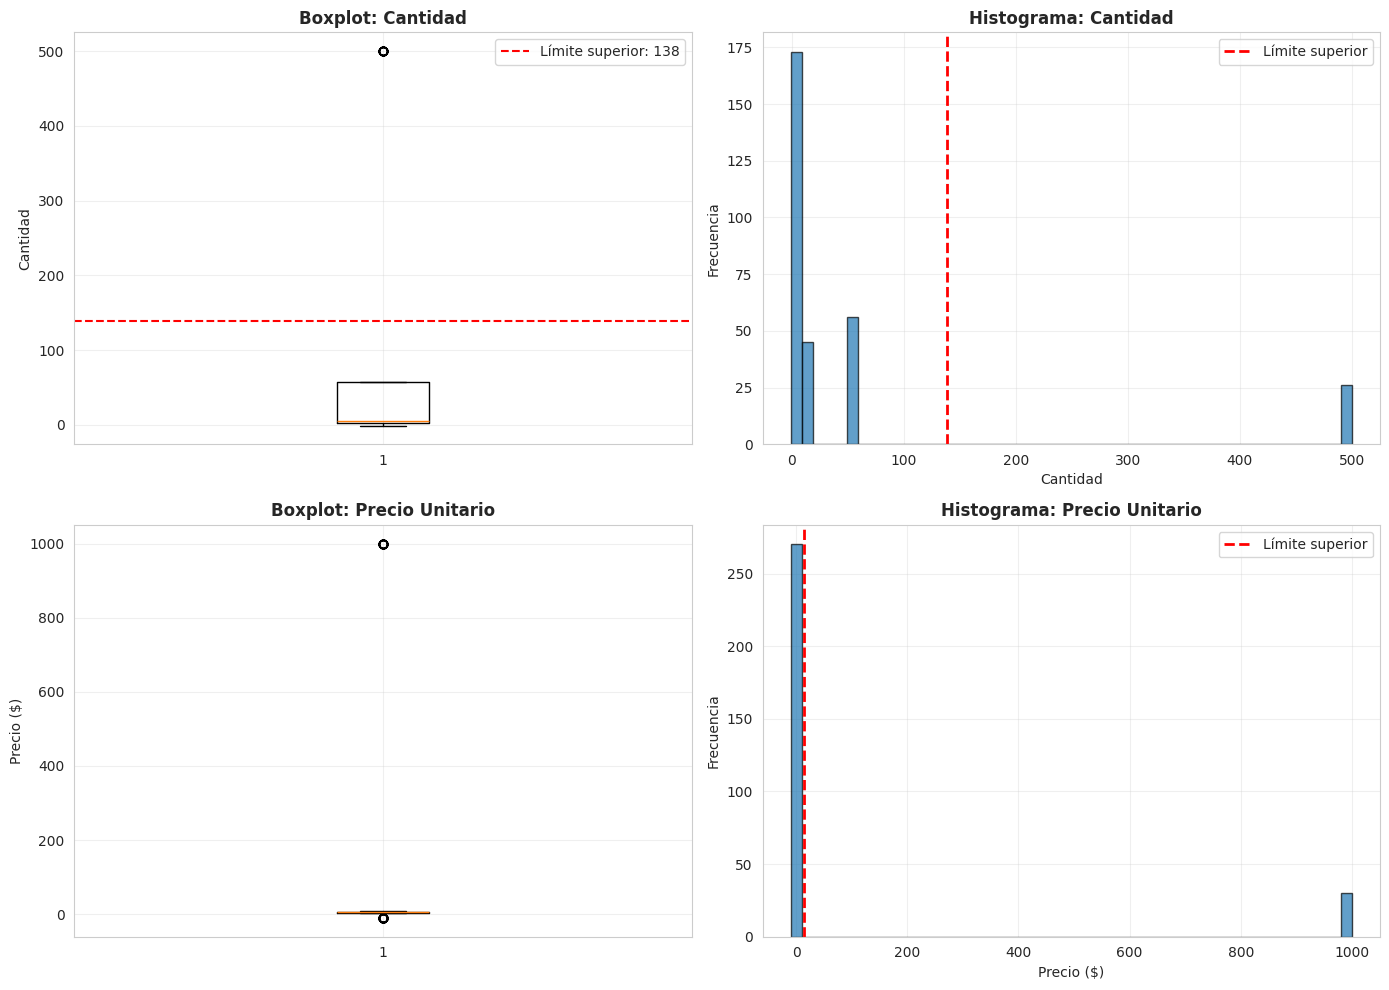


 Gráfico guardado: 'outliers_1_deteccion_iqr.png'


In [18]:
# Visualización con Boxplot e Histogramas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Crea una figura con 2 filas y 2 columnas de subgráficos

# Boxplot de cantidad
if 'cantidad' in df_imputado.columns:  # Verifica si la columna existe
    axes[0, 0].boxplot(df_imputado['cantidad'].dropna(), vert=True)  # Boxplot vertical de la columna sin nulos
    axes[0, 0].set_title('Boxplot: Cantidad', fontsize=12, fontweight='bold')  # Título del subgráfico
    axes[0, 0].set_ylabel('Cantidad', fontsize=10)  # Etiqueta del eje Y
    axes[0, 0].grid(alpha=0.3)  # Añade malla ligera
    axes[0, 0].axhline(y=limite_superior, color='r', linestyle='--', label=f'Límite superior: {limite_superior:.0f}')  # Línea del límite superior de outliers
    axes[0, 0].legend()  # Muestra la leyenda

# Histograma de cantidad
if 'cantidad' in df_imputado.columns:
    axes[0, 1].hist(df_imputado['cantidad'].dropna(), bins=50, edgecolor='black', alpha=0.7)  # Histograma con 50 bins
    axes[0, 1].axvline(limite_superior, color='r', linestyle='--', linewidth=2, label='Límite superior')  # Línea vertical del límite superior
    axes[0, 1].set_title('Histograma: Cantidad', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Cantidad', fontsize=10)
    axes[0, 1].set_ylabel('Frecuencia', fontsize=10)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

# Boxplot de precio_unitario
if 'precio_unitario' in df_imputado.columns:
    axes[1, 0].boxplot(df_imputado['precio_unitario'].dropna(), vert=True)  # Boxplot vertical
    axes[1, 0].set_title('Boxplot: Precio Unitario', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Precio ($)', fontsize=10)
    axes[1, 0].grid(alpha=0.3)

# Histograma de precio_unitario
if 'precio_unitario' in df_imputado.columns:
    axes[1, 1].hist(df_imputado['precio_unitario'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(limite_sup_precio, color='r', linestyle='--', linewidth=2, label='Límite superior')  # Línea vertical del límite superior de outliers
    axes[1, 1].set_title('Histograma: Precio Unitario', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Precio ($)', fontsize=10)
    axes[1, 1].set_ylabel('Frecuencia', fontsize=10)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

# Ajusta automáticamente el espaciado entre subgráficos para evitar que se sobrepongan etiquetas
plt.tight_layout()

# Guarda la figura como archivo PNG con alta resolución
plt.savefig('outliers_1_deteccion_iqr.png', dpi=300, bbox_inches='tight')

# Muestra la figura
plt.show()

# Mensaje informando que el gráfico fue guardado
print("\n Gráfico guardado: 'outliers_1_deteccion_iqr.png'")


## Detección de outliers con Z-SCORE

Z-SCORE:
Mide cuántas desviaciones estándar se aleja un valor de la media.

Fórmula:

$$
Z = \frac{x - \mu}{\sigma}
$$


Donde:
- x = valor
- μ = media
- σ = desviación estándar

Criterios:
- |Z| > 3: Outlier extremo (0.3% de los datos)
- |Z| > 2: Outlier moderado (5% de los datos)

In [19]:
# Ejemplo con cantidad usando Z-Score
if 'cantidad' in df_imputado.columns:  # Verifica si la columna cantidad existe en el DataFrame
    print("\nEjemplo Z-Score para cantidad")

    # Crear una serie sin valores nulos para análisis
    serie_cantidad = df_imputado['cantidad'].dropna()

    # Calcular Z-scores
    media = serie_cantidad.mean()  # Media de la serie
    std = serie_cantidad.std()     # Desviación estándar de la serie
    z_scores = (serie_cantidad - media) / std  # Fórmula del Z-score: (valor - media) / desviación estándar

    # Detectar outliers según Z-score
    outliers_z3 = serie_cantidad[np.abs(z_scores) > 3]  # Outliers con |Z| > 3 (extremos)
    outliers_z2 = serie_cantidad[np.abs(z_scores) > 2]  # Outliers con |Z| > 2 (moderados)

    # Mostrar estadísticas básicas
    print(f"\n   Estadísticas:")
    print(f"      • Media: {media:.2f}")
    print(f"      • Desv. Estándar: {std:.2f}")

    # Mostrar resultados de outliers
    print(f"\n   Outliers detectados:")
    print(f"      • |Z| > 3: {len(outliers_z3)} outliers ({(len(outliers_z3)/len(serie_cantidad))*100:.2f}%)")
    print(f"      • |Z| > 2: {len(outliers_z2)} outliers ({(len(outliers_z2)/len(serie_cantidad))*100:.2f}%)")

    # Mostrar algunos ejemplos de outliers extremos si existen
    if len(outliers_z3) > 0:
        print(f"      • Ejemplos (Z>3): {outliers_z3.head(5).tolist()}")



Ejemplo Z-Score para cantidad

   Estadísticas:
      • Media: 56.56
      • Desv. Estándar: 138.38

   Outliers detectados:
      • |Z| > 3: 26 outliers (8.67%)
      • |Z| > 2: 26 outliers (8.67%)
      • Ejemplos (Z>3): [500.0, 500.0, 500.0, 500.0, 500.0]


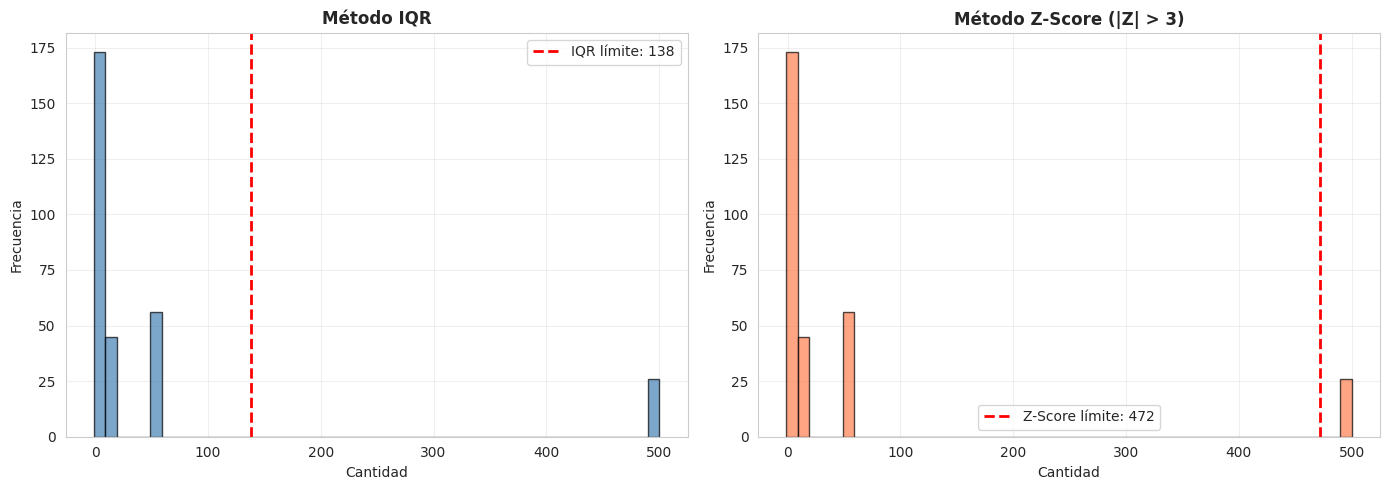


 Gráfico guardado: 'outliers_2_iqr_vs_zscore.png'


In [20]:
# Comparación visual: IQR vs Z-Score para la columna cantidad
if 'cantidad' in df_imputado.columns:  # Verifica si la columna existe
    serie = df_imputado['cantidad'].dropna()  # Eliminar valores nulos para análisis

    # Cálculo de límites usando IQR
    Q1 = serie.quantile(0.25)  # Primer cuartil (25%)
    Q3 = serie.quantile(0.75)  # Tercer cuartil (75%)
    IQR = Q3 - Q1              # Rango intercuartílico
    limite_sup_iqr = Q3 + 1.5 * IQR  # Límite superior para detectar outliers

    # Cálculo de límite usando Z-Score
    z_scores = (serie - serie.mean()) / serie.std()  # Z-scores de cada valor
    limite_sup_z = serie.mean() + 3 * serie.std()   # Límite superior para |Z| > 3

    # Crear figura con dos subgráficos lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma con límite IQR
    ax1.hist(serie, bins=50, edgecolor='black', alpha=0.7, color='steelblue')  # Histograma
    ax1.axvline(limite_sup_iqr, color='red', linestyle='--', linewidth=2, label=f'IQR límite: {limite_sup_iqr:.0f}')  # Línea límite
    ax1.set_title('Método IQR', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Cantidad', fontsize=10)
    ax1.set_ylabel('Frecuencia', fontsize=10)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Histograma con límite Z-Score
    ax2.hist(serie, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(limite_sup_z, color='red', linestyle='--', linewidth=2, label=f'Z-Score límite: {limite_sup_z:.0f}')
    ax2.set_title('Método Z-Score (|Z| > 3)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Cantidad', fontsize=10)
    ax2.set_ylabel('Frecuencia', fontsize=10)
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Ajusta automáticamente el espaciado entre subgráficos
    plt.tight_layout()

    # Guardar la figura como archivo PNG de alta resolución
    plt.savefig('outliers_2_iqr_vs_zscore.png', dpi=300, bbox_inches='tight')

    # Mostrar la figura
    plt.show()

    # Mensaje indicando que el gráfico fue guardado
    print("\n Gráfico guardado: 'outliers_2_iqr_vs_zscore.png'")

# TRATAMIENTO DE OUTLIERS

Los outliers pueden distorsionar el análisis estadístico, pero no siempre deben eliminarse. La estrategia adecuada depende de la causa y del contexto del negocio.

1. Eliminación

Qué es:

Se eliminan los registros que contienen valores atípicos.

Cuándo usarlo:

Cuando los outliers son producto de errores claros de captura o medición.

Ejemplo: un salario registrado como 999999 por error tipográfico.

Ventajas:
- Simplifica el dataset y evita distorsiones estadísticas.
- Elimina errores evidentes de captura o medición.
- Mejora la calidad de los modelos cuando los outliers son claramente inválidos.

Riesgos:
- Puede perderse información valiosa si el outlier es legítimo.
- Reduce el tamaño de la muestra, afectando la representatividad.
- Puede sesgar resultados si se eliminan casos relevantes (ej. fraudes o anomalías reales).


2. Winsorización (capping)

Qué es:

Sustituir los valores extremos por el límite superior o inferior definido.

Cuándo usarlo:
- Modelos sensibles a extremos: Regresiones, medias, y métricas que se sesgan por colas largas.
- Distribuciones con colas pesadas: Ingresos, tiempos de servicio, montos transaccionales.
- Necesidad de estabilidad: Reporting o scoring donde la robustez importa más que capturar extremos.
- Outliers por ruido: Lecturas erráticas o picos aislados sin relevancia de negocio.

Ventajas:
- Mantiene los registros completos, evitando pérdida de datos.
- Reduce el impacto de valores extremos en métricas sensibles (media, regresiones).
- Es fácil de aplicar y comprender.

Riesgos:
- Puede distorsionar la variabilidad real del fenómeno.
- Los límites elegidos pueden ser arbitrarios.
- Si se abusa, puede ocultar patrones importantes.



3. Transformación

Qué es:

Aplicar funciones matemáticas que reducen la influencia de valores extremos sin eliminar los registros.

Métodos comunes:

- **Logarítmica**  
  $$
  y = \log(x)
  $$
- **Raíz cuadrada**  
  $$
  y = \sqrt{x}
  $$

Cuándo usarlo:
- Cuando la distribución es sesgada a la derecha.  
- Cuando se requiere normalizar datos para aplicar modelos estadísticos sensibles a la normalidad.  
- En variables con gran rango de magnitudes (ejemplos como valores financieros, conteos poblacionales).  
- Para reducir la varianza y mejorar la estabilidad de algoritmos de machine learning.  

Ventajas:
- Reduce la influencia de valores extremos sin eliminarlos.
- Útil en distribuciones sesgadas.
- Permite aplicar modelos estadísticos que requieren normalidad.

Riesgos:
- Puede complicar la interpretación de los resultados.
- No elimina outliers, solo atenúa su efecto.
- Si la transformación no es adecuada, puede introducir sesgos adicionales.


4. Conservar

Qué es:

Mantener los outliers en el dataset.

Cuándo usarlo:
- Cuando representan variabilidad real del negocio.
- Casos críticos: detección de fraude, anomalías en procesos industriales, o eventos excepcionales legítimos.

Ventajas:
- Preserva información crítica en contextos donde los outliers son relevantes (fraude, anomalías, eventos raros).
- Permite descubrir patrones excepcionales que enriquecen el análisis.
- Evita la pérdida de variabilidad legítima del negocio.

Riesgos:
- Puede afectar negativamente modelos predictivos sensibles a valores extremos.
- Dificulta la interpretación si no se contextualizan adecuadamente.
- Puede generar conclusiones erróneas si se confunden con errores de datos.



In [21]:
# Crear copia para tratamiento
df_sin_outliers = df_imputado.copy()

## Método 1 Winsorización (Capping)

In [22]:
# Aplicar Winsorización a cantidad
if 'cantidad' in df_sin_outliers.columns:  # Verifica si la columna existe
    serie_original = df_sin_outliers['cantidad'].copy()  # Copia de la columna original

    # Calcular límites usando IQR
    Q1 = serie_original.quantile(0.25)  # Primer cuartil
    Q3 = serie_original.quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1                        # Rango intercuartílico
    limite_inferior = Q1 - 1.5 * IQR     # Límite inferior
    limite_superior = Q3 + 1.5 * IQR     # Límite superior

    # Contar outliers antes de aplicar capping
    outliers_antes = ((serie_original < limite_inferior) | (serie_original > limite_superior)).sum()

    # Aplicar capping: reemplaza valores fuera del límite por el valor del límite correspondiente
    df_sin_outliers['cantidad'] = serie_original.clip(lower=limite_inferior, upper=limite_superior)

    # Contar outliers después de capping (debería ser 0)
    outliers_despues = ((df_sin_outliers['cantidad'] < limite_inferior) |
                       (df_sin_outliers['cantidad'] > limite_superior)).sum()

    # Mostrar resultados
    print(f"\n   Resultado para cantidad:")
    print(f"      • Outliers antes: {outliers_antes}")
    print(f"      • Outliers después: {outliers_despues}")
    print(f"      • Límite aplicado: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"      ✓ {outliers_antes} valores ajustados al límite")


   Resultado para cantidad:
      • Outliers antes: 26
      • Outliers después: 0
      • Límite aplicado: [-79.84, 138.39]
      ✓ 26 valores ajustados al límite


In [23]:
# Aplicar Winsorización a precio_unitario
if 'precio_unitario' in df_sin_outliers.columns:  # Verifica si la columna existe
    serie_precio = df_sin_outliers['precio_unitario'].copy()  # Copia de la columna original

    # Calcular límites IQR
    Q1_p = serie_precio.quantile(0.25)
    Q3_p = serie_precio.quantile(0.75)
    IQR_p = Q3_p - Q1_p
    limite_inf_p = Q1_p - 1.5 * IQR_p
    limite_sup_p = Q3_p + 1.5 * IQR_p

    # Contar outliers antes de capping
    outliers_antes_p = ((serie_precio < limite_inf_p) | (serie_precio > limite_sup_p)).sum()

    # Aplicar capping
    df_sin_outliers['precio_unitario'] = serie_precio.clip(lower=limite_inf_p, upper=limite_sup_p)

    # Mostrar resultados
    print(f"\n   Resultado para precio_unitario:")
    print(f"      • Outliers antes: {outliers_antes_p}")
    print(f"      • Límite aplicado: [${limite_inf_p:.2f}, ${limite_sup_p:.2f}]")
    print(f"      ✓ Winsorización aplicada")



   Resultado para precio_unitario:
      • Outliers antes: 77
      • Límite aplicado: [$-5.00, $15.00]
      ✓ Winsorización aplicada


## Método 2 Transformación Logarítmica

In [24]:
# Aplicar transformación logarítmica a precio_unitario
if 'precio_unitario' in df_sin_outliers.columns:  # Verifica si la columna existe
    # Crear nueva columna transformada usando log(x + 1) para evitar log(0)
    df_sin_outliers['precio_log'] = np.log1p(df_sin_outliers['precio_unitario'])


    # Mostrar resultados

    print(f"\n   Resultado:")
    print(f"      • Columna original: precio_unitario")
    print(f"      • Columna transformada: precio_log")
    print(f"      • Rango original: [${df_sin_outliers['precio_unitario'].min():.2f}, ${df_sin_outliers['precio_unitario'].max():.2f}]")
    print(f"      • Rango transformado: [{df_sin_outliers['precio_log'].min():.2f}, {df_sin_outliers['precio_log'].max():.2f}]")



   Resultado:
      • Columna original: precio_unitario
      • Columna transformada: precio_log
      • Rango original: [$-5.00, $15.00]
      • Rango transformado: [1.25, 2.77]


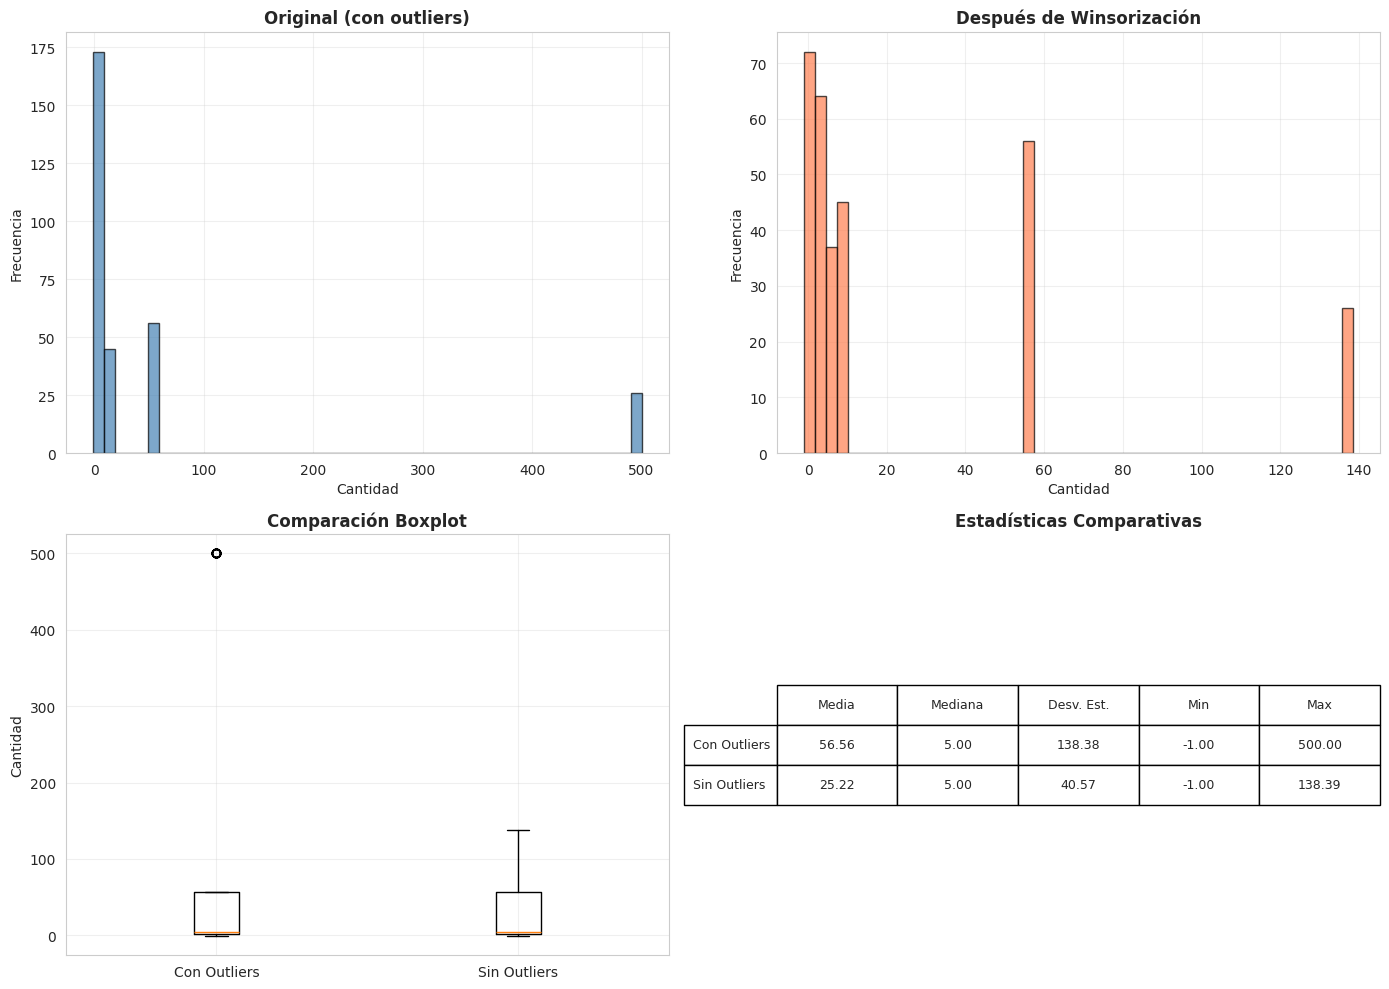


 Gráfico guardado: 'outliers_3_tratamiento.png'


In [25]:
# Visualización comparativa del tratamiento de outliers
if 'cantidad' in df_sin_outliers.columns:  # Verifica si la columna existe
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Crear figura con 2x2 subgráficos


    # Histograma de los datos originales (con outliers)

    axes[0, 0].hist(df_imputado['cantidad'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].set_title('Original (con outliers)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Cantidad', fontsize=10)
    axes[0, 0].set_ylabel('Frecuencia', fontsize=10)
    axes[0, 0].grid(alpha=0.3)


    # Histograma después de aplicar Winsorización

    axes[0, 1].hist(df_sin_outliers['cantidad'], bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[0, 1].set_title('Después de Winsorización', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Cantidad', fontsize=10)
    axes[0, 1].set_ylabel('Frecuencia', fontsize=10)
    axes[0, 1].grid(alpha=0.3)


    # Boxplot comparativo (con vs sin outliers)

    axes[1, 0].boxplot([df_imputado['cantidad'].dropna(), df_sin_outliers['cantidad'].dropna()],
                       labels=['Con Outliers', 'Sin Outliers'])
    axes[1, 0].set_title('Comparación Boxplot', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Cantidad', fontsize=10)
    axes[1, 0].grid(alpha=0.3)


    # Estadísticas comparativas en forma de tabla

    stats_data = {
        'Métrica': ['Media', 'Mediana', 'Desv. Est.', 'Min', 'Max'],  # Métricas a mostrar
        'Con Outliers': [
            df_imputado['cantidad'].mean(),
            df_imputado['cantidad'].median(),
            df_imputado['cantidad'].std(),
            df_imputado['cantidad'].min(),
            df_imputado['cantidad'].max()
        ],
        'Sin Outliers': [
            df_sin_outliers['cantidad'].mean(),
            df_sin_outliers['cantidad'].median(),
            df_sin_outliers['cantidad'].std(),
            df_sin_outliers['cantidad'].min(),
            df_sin_outliers['cantidad'].max()
        ]
    }

    # Configurar el subgráfico para mostrar la tabla
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')

    # Crear la tabla comparativa
    table = axes[1, 1].table(cellText=[[f"{v:.2f}" for v in stats_data['Con Outliers']],
                                       [f"{v:.2f}" for v in stats_data['Sin Outliers']]],
                            rowLabels=['Con Outliers', 'Sin Outliers'],
                            colLabels=stats_data['Métrica'],
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)  # Escalar la tabla para que sea legible
    axes[1, 1].set_title('Estadísticas Comparativas', fontsize=12, fontweight='bold')

    # Ajustar layout para evitar solapamientos
    plt.tight_layout()

    # Guardar la figura como PNG de alta resolución
    plt.savefig('outliers_3_tratamiento.png', dpi=300, bbox_inches='tight')

    # Mostrar la figura
    plt.show()

    # Mensaje indicando que el gráfico fue guardado
    print("\n Gráfico guardado: 'outliers_3_tratamiento.png'")


# NORMALIZACIÓN Y ESTANDARIZACIÓN


Transformación de Escala

La transformación de escala consiste en ajustar las variables a un rango común para que puedan ser comparables y procesadas de manera eficiente por los algoritmos de machine learning.

¿Por qué es importante?
- Algoritmos sensibles a la escala: KNN, SVM, Redes Neuronales dependen de distancias o gradientes.
- Unidades diferentes: Ejemplo, precios en miles vs cantidades en unidades.
- Mejorar convergencia: Optimización más rápida y estable en algoritmos iterativos.
- Facilitar comparaciones: Permite interpretar variables en un mismo rango.

Métodos principales:

1. Normalización (Min-Max Scaling)

Definición:

Escala los valores de una variable a un rango fijo, normalmente [0,1].
Se basa en los valores mínimo y máximo de la variable.

Fórmula:

$$
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$


Resultado: valores ajustados al rango [0,1].

Cuándo usarlo:

* Cuando necesitas valores en un rango específico (ej. [0,1] o [-1,1]).
* En distribuciones no normales.
* Cuando no existen outliers extremos (porque pueden distorsionar el rango).


2. Estandarización (Z-Score Normalization)

Definición:

Transforma los datos para que tengan media 0 y desviación estándar 1.
Se centra en la media y ajusta según la dispersión.

Fórmula:

$$
X_{std} = \frac{X - \mu}{\sigma}
$$


Resultado: media = 0, desviación estándar = 1.

Cuándo usarlo:
* Algoritmos que asumen distribución normal (ej. regresión logística, PCA).
* Cuando hay outliers (más robusta que la normalización).
* Para comparar variables en la misma escala aunque tengan unidades distintas.


3. Robust Scaling

Escala los datos usando la mediana y el rango intercuartílico (IQR), lo que lo hace resistente a outliers.


Fórmula:

$$
X_{robust} = \frac{X - \text{median}}{IQR}
$$


Resultado: mediana = 0, escala basada en el rango intercuartílico (IQR).

Cuándo usarlo:
* Cuando existen muchos outliers.
* En distribuciones muy asimétricas o sesgadas.
* Cuando se busca mayor resistencia a valores extremos.


## Normalización (MIN-MAX SCALING)


Resultado: Todos los valores entre [0, 1]
- 0 = valor mínimo original
- 1 = valor máximo original

In [26]:
# Crear copia para escalado
df_escalado = df_sin_outliers.copy()

In [27]:
# Ejemplo con la variable cantidad
if 'cantidad' in df_escalado.columns:  # Verifica si la columna cantidad existe en el DataFrame
    print("\nEjemplo: Normalización de cantidad")

    # Copia de la serie original para no modificarla directamente
    serie_original = df_escalado['cantidad'].copy()


    # Calcular valores mínimo y máximo originales

    valor_min = serie_original.min()  # Valor mínimo original
    valor_max = serie_original.max()  # Valor máximo original

    print(f"\n   Valores originales:")
    print(f"      • Mínimo: {valor_min:.2f}")
    print(f"      • Máximo: {valor_max:.2f}")
    print(f"      • Rango: {valor_max - valor_min:.2f}")


    # Aplicar normalización Min-Max
    scaler_minmax = MinMaxScaler()  # Inicializa el escalador Min-Max
    df_escalado['cantidad_norm'] = scaler_minmax.fit_transform(
        serie_original.values.reshape(-1, 1)
    )  # Escala los valores al rango [0, 1]


    # Mostrar resultados de la normalización
    print(f"\n   Valores normalizados:")
    print(f"      • Mínimo: {df_escalado['cantidad_norm'].min():.4f}")
    print(f"      • Máximo: {df_escalado['cantidad_norm'].max():.4f}")
    print(f"      • Media: {df_escalado['cantidad_norm'].mean():.4f}")
    print(f"      ✓ Valores escalados a rango [0, 1]")


Ejemplo: Normalización de cantidad

   Valores originales:
      • Mínimo: -1.00
      • Máximo: 138.39
      • Rango: 139.39

   Valores normalizados:
      • Mínimo: 0.0000
      • Máximo: 1.0000
      • Media: 0.1881
      ✓ Valores escalados a rango [0, 1]


## Estandarización (Z-SCORE)


Resultado: Media = 0, Desviación Estándar = 1
- Valores positivos: por encima de la media
- Valores negativos: por debajo de la media
- |X| > 2: valores inusuales (más de 2 desv. est.)

In [28]:

# Ejemplo de estandarización con la variable cantidad
if 'cantidad' in df_escalado.columns:  # Verifica si la columna 'cantidad' existe en el DataFrame
    print("\nEjemplo: Estandarización de cantidad")

    # Crear una copia de la serie original
    serie_original = df_escalado['cantidad'].copy()


    # Calcular estadísticas originales
    media_original = serie_original.mean()  # Media original
    std_original = serie_original.std()     # Desviación estándar original

    # Mostrar estadísticas antes de la transformación
    print(f"\n   Estadísticas originales:")
    print(f"      • Media: {media_original:.2f}")
    print(f"      • Desv. Estándar: {std_original:.2f}")


    # Aplicar estandarización (Z-score)
    scaler_standard = StandardScaler()  # Inicializa el escalador estándar
    df_escalado['cantidad_std'] = scaler_standard.fit_transform(
        serie_original.values.reshape(-1, 1)
    )  # Transforma los datos a media 0 y desviación estándar 1


    # Verificar resultados después de la estandarización
    print(f"\n   Después de estandarización:")
    print(f"      • Media: {df_escalado['cantidad_std'].mean():.10f}")  # Aproximadamente 0
    print(f"      • Desv. Estándar: {df_escalado['cantidad_std'].std():.10f}")  # Aproximadamente 1
    print(f"      • Rango: [{df_escalado['cantidad_std'].min():.2f}, {df_escalado['cantidad_std'].max():.2f}]")
    print(f"      ✓ Valores centrados en 0 con escala 1")



Ejemplo: Estandarización de cantidad

   Estadísticas originales:
      • Media: 25.22
      • Desv. Estándar: 40.57

   Después de estandarización:
      • Media: 0.0000000000
      • Desv. Estándar: 1.0016708449
      • Rango: [-0.65, 2.79]
      ✓ Valores centrados en 0 con escala 1


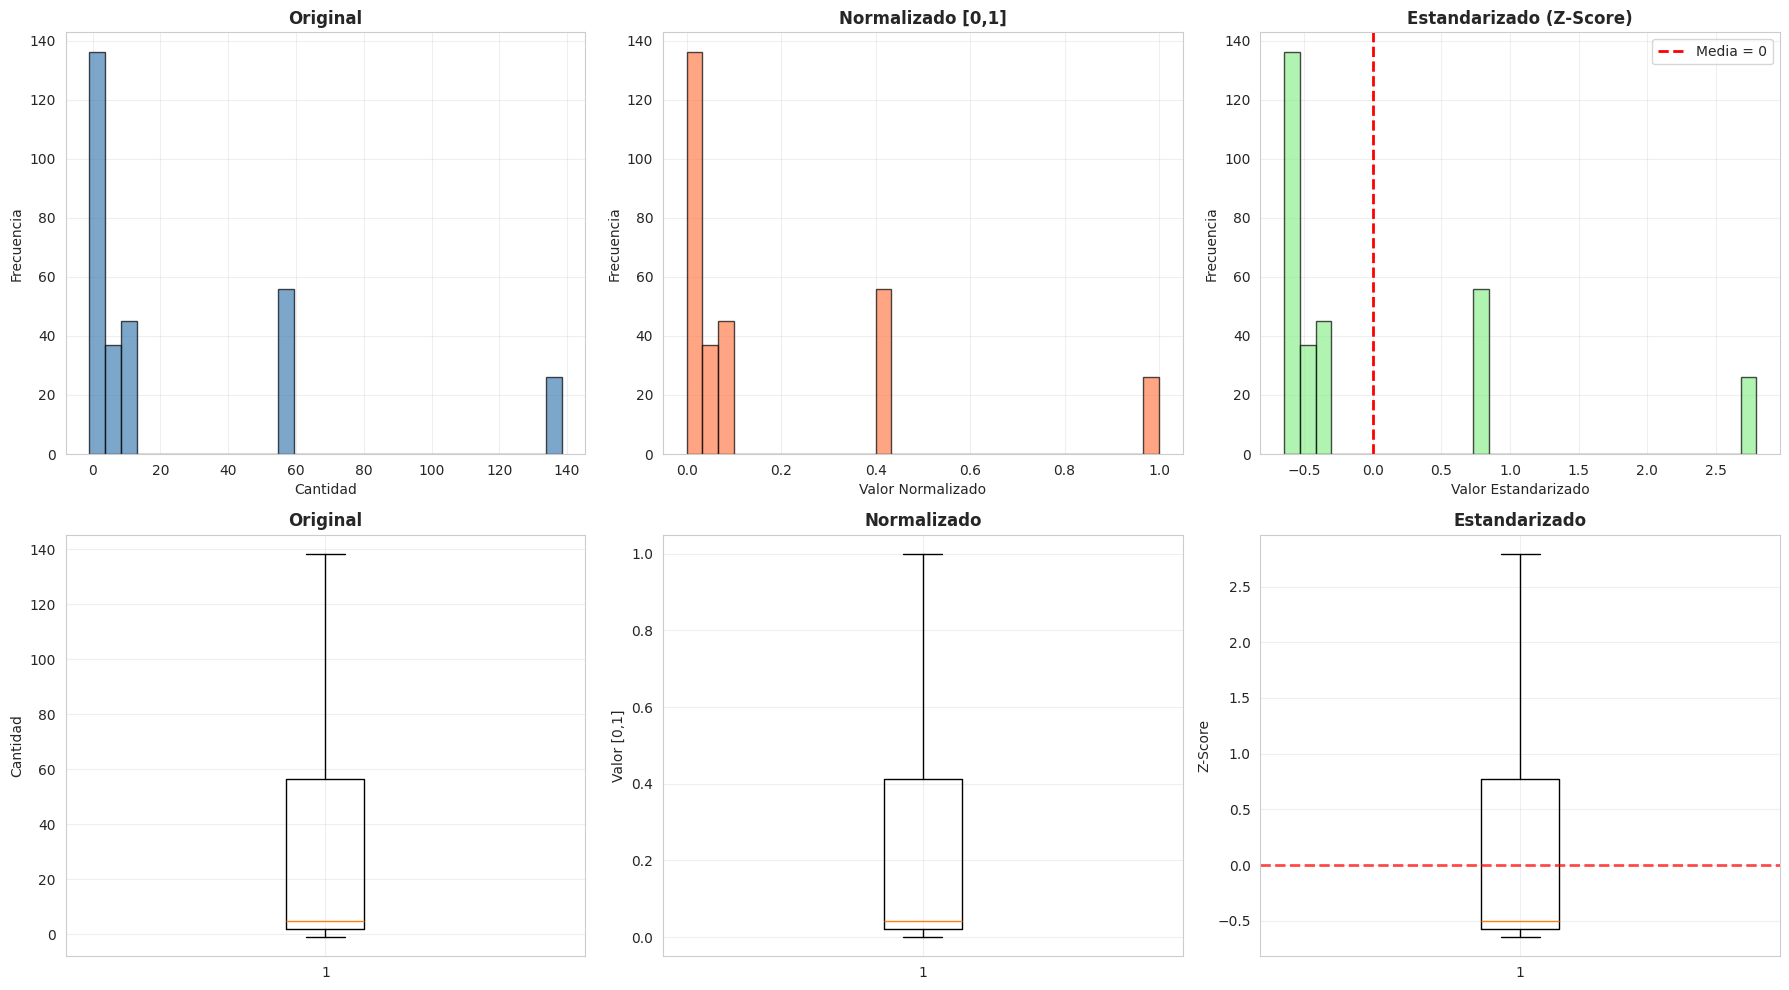


 Gráfico guardado: 'normalizacion_1_comparacion.png'


In [29]:
# Comparación Original vs Normalizado vs Estandarizado

if 'cantidad' in df_escalado.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Fila 1 Histogramas
    # Original
    axes[0, 0].hist(df_escalado['cantidad'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Cantidad', fontsize=10)
    axes[0, 0].set_ylabel('Frecuencia', fontsize=10)
    axes[0, 0].grid(alpha=0.3)

    # Normalizado
    axes[0, 1].hist(df_escalado['cantidad_norm'], bins=30, edgecolor='black', alpha=0.7, color='coral')
    axes[0, 1].set_title('Normalizado [0,1]', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Valor Normalizado', fontsize=10)
    axes[0, 1].set_ylabel('Frecuencia', fontsize=10)
    axes[0, 1].grid(alpha=0.3)

    # Estandarizado
    axes[0, 2].hist(df_escalado['cantidad_std'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    axes[0, 2].set_title('Estandarizado (Z-Score)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Valor Estandarizado', fontsize=10)
    axes[0, 2].set_ylabel('Frecuencia', fontsize=10)
    axes[0, 2].axvline(0, color='red', linestyle='--', linewidth=2, label='Media = 0')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)

    # Fila 2 Boxplots
    axes[1, 0].boxplot(df_escalado['cantidad'].dropna(), vert=True)
    axes[1, 0].set_title('Original', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Cantidad', fontsize=10)
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].boxplot(df_escalado['cantidad_norm'].dropna(), vert=True)
    axes[1, 1].set_title('Normalizado', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Valor [0,1]', fontsize=10)
    axes[1, 1].grid(alpha=0.3)

    axes[1, 2].boxplot(df_escalado['cantidad_std'].dropna(), vert=True)
    axes[1, 2].set_title('Estandarizado', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('Z-Score', fontsize=10)
    axes[1, 2].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('normalizacion_1_comparacion.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n Gráfico guardado: 'normalizacion_1_comparacion.png'")

In [30]:
# Tabla comparativa de estadísticas
if 'cantidad' in df_escalado.columns:
    comparacion = pd.DataFrame({
        'Métrica': ['Mínimo', 'Máximo', 'Media', 'Mediana', 'Desv. Est.'],
        'Original': [
            f"{df_escalado['cantidad'].min():.2f}",
            f"{df_escalado['cantidad'].max():.2f}",
            f"{df_escalado['cantidad'].mean():.2f}",
            f"{df_escalado['cantidad'].median():.2f}",
            f"{df_escalado['cantidad'].std():.2f}"
        ],
        'Normalizado': [
            f"{df_escalado['cantidad_norm'].min():.4f}",
            f"{df_escalado['cantidad_norm'].max():.4f}",
            f"{df_escalado['cantidad_norm'].mean():.4f}",
            f"{df_escalado['cantidad_norm'].median():.4f}",
            f"{df_escalado['cantidad_norm'].std():.4f}"
        ],
        'Estandarizado': [
            f"{df_escalado['cantidad_std'].min():.4f}",
            f"{df_escalado['cantidad_std'].max():.4f}",
            f"{df_escalado['cantidad_std'].mean():.4f}",
            f"{df_escalado['cantidad_std'].median():.4f}",
            f"{df_escalado['cantidad_std'].std():.4f}"
        ]
    })

    print(comparacion.to_string(index=False))

   Métrica Original Normalizado Estandarizado
    Mínimo    -1.00      0.0000       -0.6473
    Máximo   138.39      1.0000        2.7940
     Media    25.22      0.1881        0.0000
   Mediana     5.00      0.0430       -0.4991
Desv. Est.    40.57      0.2911        1.0017


# MANEJO DE DATOS CATEGÓRICOS

¿Qué son?

Las variables categóricas representan grupos o categorías en lugar de valores numéricos continuos.
Ejemplos: color, región, tipo de producto, nivel educativo.


Tipos de variables categóricas:

Nominales
- No tienen orden natural.
- Ejemplo: ['Rojo', 'Verde', 'Azul'], ['Colombia', 'México', 'Chile'].

Ordinales
- Sí tienen un orden lógico o jerárquico.
- Ejemplo: ['Pequeño', 'Mediano', 'Grande'], ['Básico', 'Intermedio', 'Avanzado'].


Tener en cuenta:

La mayoría de los algoritmos de análisis y machine learning no trabajan directamente con texto Necesitamos transformar las categorías en valores numéricos para que los modelos puedan procesarlas.

Soluciones de codificación:

1. Label Encoding
- Asigna un número entero a cada categoría.
- Ejemplo: ['Rojo', 'Verde', 'Azul'] → [0, 1, 2].

Cuándo usar:
- Variables ordinales (porque el orden importa).
- Modelos basados en árboles de decisión (no interpretan el orden como lineal).
- Evitar en variables nominales con modelos lineales (ej. regresión), porque el modelo podría interpretar un orden inexistente.

2. One-Hot Encoding
- Crea una columna binaria (0/1) por cada categoría.
- Ejemplo: Color → Color_Rojo, Color_Verde, Color_Azul.

Cuándo usar:
- Variables nominales (sin orden).
- Cuando el número de categorías es pequeño (< 10–15).
- Importante: si hay muchas categorías, el dataset puede crecer demasiado (problema de alta dimensionalidad).

3. Frequency Encoding
- Reemplaza cada categoría por la frecuencia relativa con la que aparece en el dataset.
- Ejemplo: ['A', 'B', 'A', 'C'] → [0.5, 0.25, 0.5, 0.25].

Ventaja:
- Reduce dimensionalidad y conserva información sobre la importancia de cada categoría.
- Útil en datasets grandes con muchas categorías.

4. Target Encoding
- Sustituye cada categoría por el promedio de la variable objetivo (target) para esa categoría.
- Ejemplo: si la variable objetivo es ventas, cada categoría se reemplaza por el promedio de ventas asociado.
Cuándo usar:
- Problemas de clasificación o regresión.
- Riesgo de overfitting si no se aplica correctamente (se recomienda usar validación cruzada o regularización).



In [31]:
# Crear copia para codificación
df_codificado = df_escalado.copy()

## One-hot Encoding



In [32]:
# Ejemplo con metodo_pago
if 'metodo_pago' in df_codificado.columns:
    print("\nEjemplo: One-Hot Encoding de metodo_pago")

    valores_unicos_pago = df_codificado['metodo_pago'].unique()
    print(f"\n    Métodos de pago únicos ({len(valores_unicos_pago)}):")
    print(f"      {sorted([v for v in valores_unicos_pago if pd.notna(v)])}")

    # Mostrar datos antes
    print(f"\n    Columnas antes: {len(df_codificado.columns)}")

    # Aplicar One-Hot Encoding
    df_onehot = pd.get_dummies(df_codificado, columns=['metodo_pago'], prefix='pago', drop_first=False)

    # Mostrar columnas creadas
    nuevas_columnas = [col for col in df_onehot.columns if col.startswith('pago_')]
    print(f"\n    Columnas después: {len(df_onehot.columns)}")
    print(f"    Columnas nuevas creadas ({len(nuevas_columnas)}):")
    for col in nuevas_columnas:
        count = df_onehot[col].sum()
        print(f"      • {col}: {int(count)} registros con valor 1")

    print(f"\n    One-Hot Encoding aplicado")

    # Mostrar ejemplo de registros
    print(f"\n    Ejemplo de registros transformados:")
    ejemplo = df_onehot[['id_pedido'] + nuevas_columnas].head(5)
    print(ejemplo.to_string(index=False))


Ejemplo: One-Hot Encoding de metodo_pago

    Métodos de pago únicos (5):
      [' efectivo ', 'Efectivo', 'Tarjeta', 'Transferencia']

    Columnas antes: 13

    Columnas después: 16
    Columnas nuevas creadas (4):
      • pago_ efectivo : 57 registros con valor 1
      • pago_Efectivo: 62 registros con valor 1
      • pago_Tarjeta: 59 registros con valor 1
      • pago_Transferencia: 59 registros con valor 1

    One-Hot Encoding aplicado

    Ejemplo de registros transformados:
 id_pedido  pago_ efectivo   pago_Efectivo  pago_Tarjeta  pago_Transferencia
         1             True          False         False               False
         2            False          False         False               False
         3            False           True         False               False
         4            False           True         False               False
         5            False          False         False                True


## Frequency encoding

In [33]:
# Ejemplo con region
if 'region' in df_codificado.columns:
    print("\nEjemplo: Frequency Encoding de 'region'")

    # Calcular frecuencias
    frecuencias = df_codificado['region'].value_counts(normalize=True)

    print(f"\n    Top 5 regions más frecuentes:")
    for region, freq in frecuencias.head(5).items():
        count = df_codificado['region'].value_counts()[region]
        print(f"      • {region:<20}: {freq:.4f} ({count} ventas)")

    # Aplicar frequency encoding
    df_codificado['region_freq'] = df_codificado['region'].map(frecuencias)

    print(f"\n   Nueva columna: 'region_freq'")
    print(f"      Rango: [{df_codificado['region_freq'].min():.4f}, {df_codificado['region_freq'].max():.4f}]")



Ejemplo: Frequency Encoding de 'region'

    Top 5 regions más frecuentes:
      • Norte               : 0.2237 (51 ventas)
      •  norte              : 0.2149 (49 ventas)
      • Sur                 : 0.2105 (48 ventas)
      • Oeste               : 0.1930 (44 ventas)
      • Este                : 0.1579 (36 ventas)

   Nueva columna: 'region_freq'
      Rango: [0.1579, 0.2237]
